In [1]:
import numpy as np
import pandas as pd

from matplotlib import style

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.gridspec as gridspec

from scipy.integrate import odeint
from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution
import scipy
import warnings
from tqdm import tqdm 
from p_tqdm import p_map # For parallel processing and progress bar
from functools import partial
from scipy.interpolate import interp1d

from tqdm import tqdm 
from p_tqdm import p_map # For parallel processing and progress bar
import time
from scipy import signal # for smoothing
import os

from functools import partial

cwd = "Data/"

print('Finished importing...')

Finished importing...


In [2]:
sim_counter = 0

def print_counter():
    global sim_counter 
    sim_counter += 1
    print('\r', sim_counter, sep='', end='', flush=True)
    return

In [3]:
medium_size = 14
large_size = 14

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14

plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
plt.rcParams["figure.figsize"] = (16,9)
plt.rc('grid', linestyle=':', color='gray', alpha=0.7, linewidth=2)
plt.rcParams['axes.linewidth'] = 0.5 

orange = (237/255, 125/255, 49/255, 1)
green = (0/255, 255/255, 0/255, 1)
red = (1, 0, 0, 1)

In [4]:
plt.style.use('dark_background')
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (7.5,7.5)
plt.rc('grid', linestyle=':', color='white', alpha=0.7, linewidth=2)

orange = (237/255, 125/255, 49/255, 1)
green = (0/255, 255/255, 0/255, 1)
red = (1, 0, 0, 1)

In [5]:
def derivatives(X, t, k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off):	
    # Model B.1c 
    CB       = X[0]
    S        = X[1]
    CBS      = X[2]
    C1       = X[3]
    CBC1     = X[4]
    CBC1S    = X[5]
    P2       = X[6]
    C1P2     = X[7]
    CBC1P2S  = X[8]
    CBC1P2   = X[9]
    C        = X[10]
    B        = X[11]
    BC1      = X[12]
    BC1P2    = X[13]

    return np.array([
        - d_on*CB*C1P2 + d_off*CBC1P2 - d_on*CB*C1 + d_off*CBC1 - k_on*CB*S + k_off_star*CBS + b_on*C*B - b_off*CB,
        - k_on*CB*S + k_off_star*CBS - R_on*CBC1P2*S + R_off*CBC1P2S - k_on*CBC1*S + k_off_star*CBC1S,
        k_on*CB*S - k_off_star*CBS - d_on*CBS*C1 + d_off*CBC1S - d_on*CBS*C1P2 + d_off*CBC1P2S,
        - d_on*CB*C1 + d_off*CBC1 - d_on*CBS*C1 + d_off*CBC1S - a_on*C1*P2 + a_off*C1P2 - d_on*B*C1 + d_off*BC1,
        - a_on*CBC1*P2 + a_off*CBC1P2 + d_on*CB*C1 - d_off*CBC1 - k_on*CBC1*S + k_off_star*CBC1S + b_on*C*BC1 - b_off*CBC1,
        d_on*CBS*C1 - d_off*CBC1S - a_on*CBC1S*P2 + a_off*CBC1P2S + k_on*CBC1*S - k_off_star*CBC1S,
        - a_on*CBC1*P2 + a_off*CBC1P2 - a_on*C1*P2 + a_off*C1P2 - a_on*CBC1S*P2 + a_off*CBC1P2S - a_on*BC1*P2 + a_off*BC1P2,
        - d_on*CB*C1P2 + d_off*CBC1P2 + a_on*C1*P2 - a_off*C1P2 - d_on*CBS*C1P2 + d_off*CBC1P2S - d_on*B*C1P2 + d_off*BC1P2,
        R_on*CBC1P2*S - R_off*CBC1P2S + a_on*CBC1S*P2 - a_off*CBC1P2S + d_on*CBS*C1P2 - d_off*CBC1P2S,
        a_on*CBC1*P2 - a_off*CBC1P2 + d_on*CB*C1P2 - d_off*CBC1P2 - R_on*CBC1P2*S + R_off*CBC1P2S + b_on*C*BC1P2 - b_off*CBC1P2,
        - b_on*C*B + b_off*CB - b_on*C*BC1 + b_off*CBC1 - b_on*C*BC1P2 + b_off*CBC1P2,
        - b_on*C*B + b_off*CB - d_on*B*C1 + d_off*BC1 - d_on*B*C1P2 + d_off*BC1P2,
        d_on*B*C1 - d_off*BC1 - b_on*C*BC1 + b_off*CBC1 - a_on*BC1*P2 + a_off*BC1P2,
        d_on*B*C1P2 - d_off*BC1P2 - b_on*C*BC1P2 + b_off*CBC1P2 + a_on*BC1*P2 - a_off*BC1P2])

In [6]:
# Dictionary for quick lookup of index corresponding to variable name
var = {
    'CB':0,
    'S':1,
    'CBS':2,
    'C1':3,
    'CBC1':4,
    'CBC1S':5,
    'P2':6,
    'C1P2':7,
    'CBC1P2S':8,
    'CBC1P2':9,
    'C':10,
    'B':11,
    'BC1':12,
    'BC1P2':13
}

In [7]:
def hetero_dimerisation_limit(kd, x_0, y_0):
    ''' Yeilds the concentration of the dimer in the limit as t goes to infinity '''
    return (x_0 + y_0 + kd - np.sqrt((x_0 + y_0 + kd)**2 - 4 * x_0 * y_0)) / 2

In [8]:
def ODE_limit(initial_concentrations, t, k_on, d_on, d_off, R_on, R_off, a_on, a_off, k_off_star, b_on, b_off):
    arr = []
    differences = []
    for i in tqdm(range(len(k_on))):
        Y = odeint(derivatives, initial_concentrations[i], t, args=(k_on[i], d_on[i], d_off[i], a_on[i], a_off[i], R_on[i], R_off[i], k_off_star[i], b_on[i], b_off[i],))
        arr.append(Y[-1, :])
        differences.append(np.max(Y[-1, :] - Y[-int(0.2*len(t)), :]))
        
    percentage_diff = np.max(100*np.array(differences).flatten())
    print("Max Percentage difference over the last 200 points = {:0.2f}".format(percentage_diff))
    return np.array(arr)

In [9]:
def single_component(t, k_OFF, A):
    return A * (1 - np.exp(-k_OFF * t))

def single_component_normalised(t, k_OFF):
    return 1 - np.exp(-k_OFF * t)

def two_components(t, k_S, k_N):
    return S_ - S_ * np.exp(-k_S * t) + N_ - N_ * np.exp(-k_N * t)

def two_components_normalised(t, k_S, k_N, A):
    return A * np.exp(-k_S * t) + (1 - A) * np.exp(-k_N * t)

def two_components_full(t, k_S, k_N, S, N):
    return S - S * np.exp(-k_S * t) + N - N * np.exp(-k_N * t)

In [10]:
def generate_apparent_off_rates_full(k_on,  
                                     d_on, 
                                     a_on, 
                                     a_off, 
                                     R_on, 
                                     R_off, 
                                     k_off_star, 
                                     b_on, 
                                     b_off, 
                                     initial_concentrations,
                                     d_off,
                                     percentage_left=0, 
                                     measurement_time=20000, 
                                     measurement_steps=int(1E3)):
    '''
    Generates an in silico FRAP measurement that is fit using a 1 component reaction limited model (DNA binding model) by removing all bound species and then observing their recoveries
    '''
    times = np.linspace(0, measurement_time, num=measurement_steps)
    # Allow system to go to equilibrium before bleaching
    Y = odeint(derivatives, initial_concentrations, times, args=(k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    Y_copy = Y.copy()
    bleached_concs = Y[-1, :]
    # Reset the concentrations according to what percentage of the bound molecules is bleached
    bleached_concs[var['S']] = Y[0, var['S']] 
    bleached_concs[var['CBS']] = percentage_left * bleached_concs[var['CBS']] 
    bleached_concs[var['CBC1S']] = percentage_left * bleached_concs[var['CBC1S']] 
    bleached_concs[var['CBC1P2S']] = percentage_left * bleached_concs[var['CBC1P2S']]
    
    # Simulate system after bleaching
    Y2 = odeint(derivatives, bleached_concs, times, args=(k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    
    t_end = int(0.8*measurement_steps)
    t_ = times[:-t_end]
    try:  
        all_unbound = Y_copy[-1, var['CB']] + Y_copy[-1, var['CBC1']] + Y_copy[-1, var['CBC1P2']]
        all_bound = Y_copy[-1, var['CBS']] + Y_copy[-1, var['CBC1S']] + Y_copy[-1, var['CBC1P2S']]
        k_off_pred = k_on * Y_copy[-1, var['S']] * (all_unbound / all_bound)
        
        result = np.zeros(15)
        result[0] = k_off_pred
        result[1:] = Y_copy[-1, :]
        return result

    except Exception as e:
        params = [k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off]
        print('ERROR: {:} with values: \n Y_bleached_p={:}  \n Y_bleached_p_min={:} \n params = {:} \n Y_bleached_p_2 = {:} \n Y_bleached_p_max = {:} \n Y_bleached_p_3 = {:} \n Returning zero'.format(e, Y_bleached_p, np.min(Y_bleached_p), params, Y_bleached_p_2, Y_bleached_p_max, Y_bleached_p_3))
        print('ERROR: {:} \n Returning None'.format(e))
        result = np.zeros(15)
        result[0] = 0
        result[1:] = Y2[-1, :]
        return result
    

In [11]:
class DNA_binding_model_B1:
    def __init__(self, samples, y0s, measurement_time, measurement_steps, C1_P2_Kd, CB_EBOX_Kd, CLK_B1_Kd, B1_C1_Kds, cores=4):
        self._y0s = y0s
        self._samples = int(samples)
        self._measurement_time = measurement_time
        self._measurement_steps = measurement_steps
        self._cores = cores
        self._C1_P2_Kd = C1_P2_Kd
        self._CB_EBOX_Kd = CB_EBOX_Kd
        self._CLK_B1_Kd = CLK_B1_Kd
        self._B1_C1_Kds = B1_C1_Kds

    def full_simulate(self, parameters):
        k_on, d_on, a_on, R_on, R_off, b_on = [float(x) for x in parameters]
        k_off_star = self._CB_EBOX_Kd * k_on
        a_off = self._C1_P2_Kd * a_on
        b_off = self._CLK_B1_Kd * b_on
        
        d_offs = self._B1_C1_Kds * d_on
        
        print_counter()
        result = np.zeros([self._samples, 15])
        result = p_map(partial(generate_apparent_off_rates_full,
                                        k_on, 
                                        d_on, 
                                        a_on, 
                                        a_off, 
                                        R_on, 
                                        R_off, 
                                        k_off_star, 
                                        b_on, 
                                        b_off, 
                                        measurement_time=self._measurement_time, 
                                        measurement_steps=self._measurement_steps), 
                                np.array(self._y0s), np.array(d_offs), num_cpus=self._cores, leave=False, disable=True)

        return np.array(result)
    
    def fit(self, param_bounds, data_means, data_variances, maxiter=1, polish=True):
        #data = np.array(data_means, data_variances)
        def sum_of_squared_errors(params):
            val = self.full_simulate(params)[:, 0]
            SSE = 0
            chi_squared = np.power((data_means - val), 2)/data_variances  #np.power((data_means - val), 2)/data_variances  
            SSE = np.sum(chi_squared)
            return SSE
        
        def generate_Initial_Parameters(bounds):
            boundsReshape = tuple(zip(*bounds))
            parameterBounds = []
            for i in range(len(boundsReshape)):
                parameterBounds.append(boundsReshape[i])
            print(np.array(parameterBounds).shape)
            print(parameterBounds)
            diff_evolution = scipy.optimize.differential_evolution(sum_of_squared_errors, parameterBounds, disp=True, maxiter=maxiter, polish=True)
            minimised = scipy.optimize.minimize(sum_of_squared_errors, diff_evolution.x, bounds=parameterBounds)
            print(minimised)
            return diff_evolution, minimised, diff_evolution.x, diff_evolution.fun
        
        diff_evolution, minimised, fitted_params, fitness = generate_Initial_Parameters(param_bounds)
        print('Fitted params: ')
        print(fitted_params)
        fitted_solution = self.full_simulate(fitted_params)
        
        return diff_evolution, minimised, fitted_params, fitted_solution, fitness

In [12]:
measured_param_dists = pd.read_excel(os.path.join(cwd, 'allValuesReferenceTable.xlsx'), sheet_name='MeasuredParamtersDistributions', header=[1, 2, 3])
measured_param_dists

Unnamed: 0_level_0    TG-BMAL1                            TG-BMAL1xCRY1  \
     Unnamed: 0_level_1        kOFF                                     kOFF   
     Unnamed: 0_level_2 Fibroblasts Aveolar Mθ    PECS    BMDM        Pooled   
0                   NaN      0.2752     0.4164  0.1636     NaN        0.5734   
1                   NaN      0.4403     0.7832  0.2445  0.2555        0.4684   
2                   NaN      0.3790     0.3345  0.2541  0.6274        0.4566   
3                   NaN      0.4001     0.2721  0.2984  0.4654        0.5041   
4                   NaN      0.3398     0.3428  1.2756  0.6341        0.2638   
...                 ...         ...        ...     ...     ...           ...   
1682                NaN         NaN        NaN     NaN     NaN           NaN   
1683                NaN         NaN        NaN     NaN     NaN           NaN   
1684                NaN         NaN        NaN     NaN     NaN           NaN   
1685                NaN         NaN        NaN     NaN     NaN           NaN   
1686                NaN         NaN        NaN     NaN     NaN           NaN   

     LV-BMAL1:CLOCK       BMAL1                       ...   BMAL1xCRY1  \
               kOFF   Conc (nM)                       ...    Diffusion   
       LV2-WT-Bmal1 Fibroblasts Aveolar Mθ      PECS  ... BMAL1_Pooled   
0            0.5037    7.179150   8.882740  3.347469  ...     0.476208   
1            0.2629   11.373760  10.881390  8.641375  ...     0.294933   
2            0.2817    8.214091  10.970670  6.228474  ...     0.662486   
3            1.1838    7.952958  16.237790  3.597363  ...     0.489105   
4            0.1367    7.136958   6.076025  5.532853  ...     0.642596   
...             ...         ...        ...       ...  ...          ...   
1682            NaN   11.801990        NaN       NaN  ...          NaN   
1683            NaN    8.850902        NaN       NaN  ...          NaN   
1684            NaN   12.756440        NaN       NaN  ...          NaN   
1685            NaN    7.502801        NaN       NaN  ...          NaN   
1686            NaN    7.917856        NaN       NaN  ...          NaN   

                            LV1-CRY1            LV1-PER2                      \
                           Diffusion           Diffusion                       
     CRY1_Pooled Unnamed: 23_level_2 Unnamed: 24_level_2 Unnamed: 25_level_2   
0       1.164704            1.356272            0.108505                 NaN   
1       0.728200            1.661385            0.187150                 NaN   
2       0.663132            1.181511            0.596182                 NaN   
3       0.786792            0.989835            0.149888                 NaN   
4       0.592117            0.922632            0.178628                 NaN   
...          ...                 ...                 ...                 ...   
1682         NaN                 NaN                 NaN                 NaN   
1683         NaN                 NaN                 NaN                 NaN   
1684         NaN                 NaN                 NaN                 NaN   
1685         NaN                 NaN                 NaN                 NaN   
1686         NaN                 NaN                 NaN                 NaN   

                                                                  \
                                                                   
     Unnamed: 26_level_2 Unnamed: 27_level_2 Unnamed: 28_level_2   
0                    NaN                 NaN                 NaN   
1                    NaN                 NaN                 NaN   
2                    NaN                 NaN                 NaN   
3                    NaN                 NaN                 NaN   
4                    NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
1682                 NaN                 NaN                 NaN   
1683                 NaN                 NaN  

In [13]:
measured_param_single_values = pd.read_excel(os.path.join(cwd, 'allValuesReferenceTable.xlsx'), sheet_name='MesuredParametersSingleValues', header=[1, 2, 3], index_col=0)
measured_param_single_values

BMAL1:CLOCK                         BMAL1:CRY1 NLSEGFP:CLOCK  \
          kd (nM)                            kd (nM)       kd (nM)   
           LV2-WT    LV2-L95E LV2-V435R       Pooled           LV2   
Mean   147.644673  147.710634       NaN    50.332424           NaN   
StDev    9.837618    7.485626       NaN     1.078076           NaN   
N      136.000000  274.000000       NaN  1039.000000           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   

        PER1:CRY1   PER1:CRY2                                                  \
          kd (nM)     kd (nM)                                                   
              LV2         LV2 LV2.1 LV2.2 LV2.3 LV2.4 LV2.5 LV2.6 LV2.7 LV2.8   
Mean   150.916802  202.474737   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
StDev   12.527938   26.621013   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
N      120.000000   93.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                    
                    
      LV2.9 LV2.10  
Mean    NaN    NaN  
StDev   NaN    NaN  
N       NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN

In [14]:
pooled_data = pd.read_excel(os.path.join(cwd, 'allValuesForHistogram.xlsx'), sheet_name='Variables')
pooled_data

,[Per2],[Bmal1],[Cry1]
0,Taken from Per2::Venus lung fibroblasts at bas...,Taken from Venus::Bmal1 all cells at basal con...,NaN
1,NaN,18.8704,2.981959
2,NaN,34.1538,4.179593
3,NaN,13.2102,3.011334
4,NaN,10.1185,4.771489
...,...,...,...
2107,NaN,1.60623,NaN
2108,NaN,4.22581,NaN
2109,NaN,2.52152,NaN
2110,NaN,1.69514,NaN


In [15]:
timelapse_data = pd.read_csv(os.path.join(cwd, 'Bmal1xCry1 3-3-21 XY Mean and Error.csv'))
timelapse_data

,Unnamed: 0,Interaction,Interaction.1,Interaction.2,Bmal1 Concentration,Bmal1 Concentration.1,Bmal1 Concentration.2,Bmal1 Diffusion,Bmal1 Diffusion.1,Bmal1 Diffusion.2,...,Bmal1 Alpha.2,Cry1 Concentration,Cry1 Concentration.1,Cry1 Concentration.2,Cry1 Diffusion,Cry1 Diffusion.1,Cry1 Diffusion.2,Cry1 Alpha,Cry1 Alpha.1,Cry1 Alpha.2
0,24,46.80251,2.227670,136,22.56,7.084,136,0.5879,0.2577,136,...,136,5.877,3.052,136,0.6706,0.3646,136,0.4137,0.10070,136
1,28,38.81192,2.088515,143,20.14,6.089,143,0.5777,0.2584,143,...,143,5.718,2.714,143,0.5612,0.3153,143,0.3913,0.09902,143
2,32,52.42218,3.421946,173,21.45,6.764,173,0.5416,0.2493,173,...,173,7.283,6.716,173,0.5655,0.3184,173,0.4010,0.10430,173
3,36,51.65048,2.351429,131,26.93,8.930,131,0.6042,0.2705,131,...,131,6.256,4.162,131,0.7180,0.3308,131,0.4203,0.09287,131
4,40,65.11347,3.358420,158,33.32,13.610,158,0.5363,0.2682,158,...,158,6.686,3.958,158,0.6882,0.3970,158,0.4043,0.10860,158
5,44,54.17862,2.832088,121,27.70,8.804,121,0.6037,0.2397,121,...,121,6.099,3.137,121,0.7552,0.3677,121,0.4097,0.08304,121
6,48,41.71945,2.266186,132,23.53,8.496,132,0.5974,0.2393,132,...,132,5.959,2.458,132,0.6258,0.3123,132,0.4123,0.09710,132


In [16]:
kOFF_timelapse_data = pd.read_csv(os.path.join(cwd, 'kOFF error allReps.csv'))
kOFF_timelapse_data

,Time (hours after dexamethasone),Mean,SD,N
0,24,2.732,1.082,48
1,28,2.399,1.215,70
2,32,2.359,1.251,82
3,36,2.594,1.079,63
4,40,3.038,1.499,82
5,44,2.733,1.279,64
6,48,2.513,1.168,65


In [17]:
per_data = pd.read_csv(os.path.join(cwd, 'Smyllie-PER2-Protein trace.csv'))
per_data

,X,LOWESS of Per2 Protein,LOWESS of Per2 Protein.1,LOWESS of Per2 Protein.2
0,0.000000,1.507303,0.642413,8
1,0.277213,1.800158,0.601391,8
2,0.554425,2.093012,0.582516,8
3,0.831638,2.385867,0.587924,8
4,1.108850,2.678722,0.616978,8
...,...,...,...,...
283,78.451150,7.981321,2.194489,8
284,78.728362,7.965996,2.336698,8
285,79.005575,7.950672,2.492308,8
286,79.282787,7.935347,2.658968,8


In [18]:
t = per_data['X']
p2_data = per_data['LOWESS of Per2 Protein'].to_numpy()

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


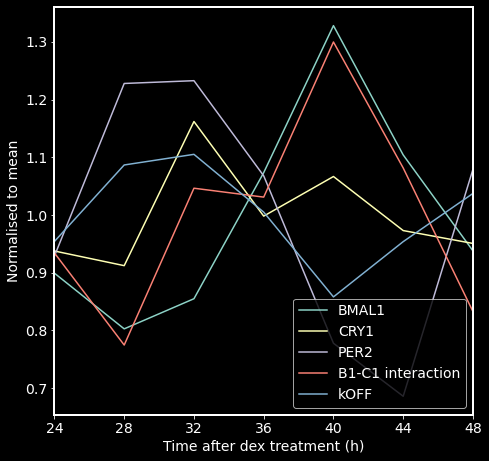

In [19]:
samples = 7
tps = np.linspace(24, 48, num=samples) # Timepoints where to evaluate the interpolation
exp_t = timelapse_data['Unnamed: 0']

Bmal1 = interp1d(exp_t, timelapse_data['Bmal1 Concentration'], kind='quadratic')
bmal1_to_clock_ratio = 1.903 # bmal1 for every clock
Clock = Bmal1(tps) / bmal1_to_clock_ratio
Cry1 = interp1d(exp_t, 2.083*timelapse_data['Cry1 Concentration'], kind='quadratic') 
Per2 = interp1d(t, p2_data, kind='quadratic') 

kd_CB_C1s = interp1d(exp_t, timelapse_data['Interaction'], kind='quadratic') 
kd_CB_C1s_std = interp1d(exp_t, timelapse_data['Interaction.1'], kind='quadratic') 
kd_CB_C1s_N = interp1d(exp_t, timelapse_data['Interaction.2'], kind='quadratic') 
kd_SEM = np.power(1*(kd_CB_C1s_std(tps)/kd_CB_C1s_N(tps)), 2)

kOFF = interp1d(kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['Mean'], kind='quadratic') 
kOFF_std = interp1d(kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['SD'], kind='quadratic')
kOFF_N = interp1d(kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['N'], kind='quadratic')
# convert into off rate. Currently it is in residence time
kOFF = 1/kOFF(tps)
kOFF_std = 1/kOFF_std(tps)
kOFF_95_CI_on_mean = 1.96*(kOFF_std/kOFF_N(tps))
kOFF_SEM = 1*(kOFF_std/kOFF_N(tps))

plt.plot(tps, Bmal1(tps)/np.mean(Bmal1(tps)), label='BMAL1')
plt.plot(tps, Cry1(tps)/np.mean(Cry1(tps)), label='CRY1')
plt.plot(tps, Per2(tps)/np.mean(Per2(tps)), label='PER2')
plt.plot(tps, kd_CB_C1s(tps)/np.mean(kd_CB_C1s(tps)), label='B1-C1 interaction')
plt.plot(tps, kOFF/np.mean(kOFF), label='kOFF')
#plt.plot(tps, Clock/np.mean(Clock), label='Clock')

plt.xlim([24, 48])
plt.xlabel('Time after dex treatment (h)')
plt.ylabel('Normalised to mean')
plt.xticks([24, 28, 32, 36, 40, 44, 48])
plt.legend()

In [20]:
'''
    CB       = X[0]
    S        = X[1]
    CBS      = X[2]
    C1       = X[3]
    CBC1     = X[4]
    CBC1S    = X[5]
    P2       = X[6]
    C1P2     = X[7]
    CBC1P2S  = X[8]
    CBC1P2   = X[9]
    C        = X[10]
    B        = X[11]
    BC1      = X[12]
    BC1P2    = X[13]
'''

samples = 7

N_A = 6.022E23
kd_CB = measured_param_single_values['BMAL1:CLOCK']['kd (nM)']['LV2-WT']['Mean'] # nM Disassociation constant between Clock and Bmal1
kd_CB_C1 = measured_param_single_values['BMAL1:CRY1']['kd (nM)']['Pooled']['Mean']  # nM Disassociation constant between Bmal1 and Cry1
kd_C1_P2 = measured_param_single_values['PER2:CRY1']['kd (nM)']['LV2']['Mean'] # nM Disassociation constant between Per2 and Cry1
CB_EBOX_Kd = 10 # nM as measured by Carrie Partch
print(kd_CB)

D = np.mean(measured_param_dists['BMAL1xCRY1']['Diffusion']['BMAL1_Pooled'])     
a = 2.04E-3  # Size of promoter / searchable target in um, 6 * 0.34 length of a base pair)
V = 926.1E-15 # ±437.9 µm3 (n=116) Volume in fL as measured using Hoeschst staining of ALF cells

S = 3436 # Specific Binding sites
S = S * 1E9 / (N_A * V)
print('S = {:} nM'.format(S))

initial_concentrations = np.array([np.array([0.0]*14)]*samples)

initial_concentrations[:, var['S']] = S
initial_concentrations[:, var['B']] = Bmal1(tps)
initial_concentrations[:, var['C']] = Clock
initial_concentrations[:, var['C1']] = Cry1(tps)
initial_concentrations[:, var['P2']] = Per2(tps)
initial_concentrations = initial_concentrations.astype('float64')

n_states = 1
n_times = samples

true_params = [9.83906286e-03,   # k_on
               5.40760014e+01,    # k_off
               3.63302761e-02,   # d_on
               1.79972287e-02,   # a_on
               1.36750328e-02,   # R_on
               6.12090423e+00,   # R_off
               1E-2]   # b_on 

fitted_params = [0.02684237, # k_on
                 1.15950765, # d_on
                 7.79829319, # a_on
                 0.07119545, # R_on
                 12.53193821, # R_off
                 0.7362028] # b_on

ode_model = DNA_binding_model_B1(samples, initial_concentrations, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s(tps), cores=20)

t0 = time.time()
result = ode_model.full_simulate(fitted_params)
kOFF_sim = result[:, 0]
Y = np.array([el[1:] for el in result])
t_end = time.time()
print('Time taken = {:0.2f}'.format(t_end-t0))

147.6446725113458
S = 6.161046970595631 nM
1Time taken = 0.28


In [21]:
fitted_params = [0.02684237, # k_on
                 1.15950765, # d_on
                 7.79829319, # a_on
                 0.07119545, # R_on
                 12.53193821, # R_off
                 0.7362028] # b_on

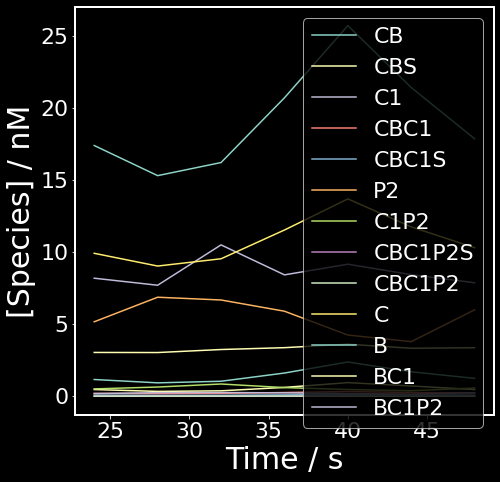

In [73]:
'''plt.plot(t, Y_C1_P2[:, var['CBS']], label="CBS")
plt.plot(t, Y_C1_P2[:, var], label="CBN")
plt.plot(t, Y_C1_P2[:, 2], label="CBC1S")
plt.plot(t, Y_C1_P2[:, 3], label="CBC1N")
plt.plot(t, Y_C1_P2[:, 4], label="CBSP2")
plt.plot(t, Y_C1_P2[:, 5], label="CBNP2")
plt.plot(t, Y_C1_P2[:, 6], label="CBC1SP2")
plt.plot(t, Y_C1_P2[:, 7], label="CBC1NP2")
plt.plot(t, Y_C1_P2[:, 8], label="CB")
plt.plot(t, Y_C1_P2[:, 9], label="CBC1")
plt.plot(t, Y_C1_P2[:, 10], label="C1P2")
plt.plot(t, Y_C1_P2[:, 11], label="S")
plt.plot(t, Y_C1_P2[:, 12], label="N")
plt.plot(t, Y_C1_P2[:, 13], label="C1")
plt.plot(t, Y_C1_P2[:, 14], label="P2")'''

for key, value in var.items():
    if key == 'N' or key == 'S' or key=='CBN':
        continue
    plt.plot(tps, Y[:, value], label=key)

plt.legend()

plt.xlabel('Time / s')
plt.ylabel('[Species] / nM')

medium_size = 22
large_size = 30

plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

In [23]:
TP = 4 #T40

In [24]:
samples = 100
S1 = 1000 # Average over available ChiP data for a variety of tissues. Specific Binding sites
S1 = S * 1E9 / (N_A * V)

S2 = 3436 # Average over available ChiP data for a variety of tissues. Specific Binding sites
S2 = S2 * 1E9 / (N_A * V)

S3 = 10000 # Average over available ChiP data for a variety of tissues. Specific Binding sites
S3 = S3 * 1E9 / (N_A * V)

print('S = {:} nM'.format(S))
t_long = np.linspace(0, 1E5, num=20000) 
initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

PER2s = np.linspace(0, 160, num=samples)
initial_concentrations1[:, var['P2']] = PER2s
initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['B']] = Bmal1(tps)[TP] #np.mean(Bmal1(tps))# 
initial_concentrations1[:, var['C']] = Clock[TP] # np.mean(Clock) #  
#initial_concentrations1[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations1[:, var['C1']] = Cry1(tps)[TP] #np.mean(Cry1(tps)) #  

initial_concentrations2[:, var['P2']] = PER2s
initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['B']] = Bmal1(tps)[TP] #np.mean(Bmal1(tps))# 
initial_concentrations2[:, var['C']] = Clock[TP] # np.mean(Clock) #  
#initial_concentrations2[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations2[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

initial_concentrations3[:, var['P2']] = PER2s
initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['B']] = Bmal1(tps)[TP] # np.mean(Bmal1(tps))# 
initial_concentrations3[:, var['C']] = Clock[TP] # np.mean(Clock) # 
#initial_concentrations3[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations3[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

k_on = fitted_params[0] # 6.09958629e-01
k_off_star = CB_EBOX_Kd * k_on
d_on = fitted_params[1] # 7.77793404e-01
d_off = kd_CB_C1s(tps)[TP] * d_on # np.mean(kd_CB_C1s(tps)) * d_on # 
a_on = fitted_params[2] # 5.61745347e-01
a_off = kd_C1_P2 * a_on
R_on = fitted_params[3] # 1.79972287e-02 # from model A fitting #k_on
R_off = fitted_params[4] # 3.84000082e+00 # from model A fitting #4.41331323e+01
b_on = fitted_params[5] #8.16182898e-03
b_off = kd_CB * b_on
        
k_ons = np.array([k_on] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')

Y_PER2_1s = ODE_limit(initial_concentrations1, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_PER2_2s = ODE_limit(initial_concentrations2, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_PER2_3s = ODE_limit(initial_concentrations3, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_PER2_1s)
#np.savetxt

  4%|▍         | 4/100 [00:00<00:02, 38.99it/s]

S = 6.161046970595631 nM


  3%|▎         | 3/100 [00:00<00:03, 29.17it/s]

Max Percentage difference over the last 200 points = 0.00


  3%|▎         | 3/100 [00:00<00:03, 25.97it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 100/100 [00:03<00:00, 25.53it/s]

Max Percentage difference over the last 200 points = 0.00


In [29]:
k_off_star

0.178122916

In [31]:
1/d_off #  Cry1 - Bmal1

0.067015543683457

In [32]:
1/a_off # Cry1 - Per2

0.01234166172070151

In [33]:
1/b_off # Clock - Bmal1

0.07072590931452588

In [75]:
k_on_   = 9.83906286e-03
k_off_  = 5.40760014e+01
d_on_ = 3.63302761e-02
R_on_ = 1.79972287e-02
R_off_ = 3.84000082e+00
a_on_ =  9.95856614e-02

kd_C1_P2_ = 50 # measured_param_single_values['PER1:CRY1']['kd (nM)']['LV2']['Mean'] # nM Disassociation constant between Per2 and Cry1
CB_EBOX_Kd = 10 # nM as measured by Carrie Partch

print('** d_off = {:}'.format(1/(np.mean(kd_CB_C1s(tps))*d_on_)))
print('a_off = {:}'.format(1/(kd_C1_P2_*a_on_)))



** d_off = 0.5494083711115071
a_off = 0.20083212501513797


In [35]:
k_on__       = 9.66431075e-03
k_off__      = 1.04524679e+01
d_on__       = 4.61800980e-03
Kd_B_C1__    = 9.11863261e+01
a_on__       = 2.75594824e-02
R_off__      = 6.00779089e+01
b_on__       = 9.78005848e-02
p_on__       = 9.97475323e-02
Kd_B_C1P2__  = 2.30521641e+00

In [36]:
print('d_off__ = {:}'.format(1/(np.mean(kd_CB_C1s(tps))*d_on__)))
print('a_off__ = {:}'.format(1/(82*a_on__)))

d_off__ = 4.322242411467451
a_off__ = 0.4425018501515656


In [37]:
k_on = 6.09958629e-01
k_off = 2.38284056e+01
k_off_star = CB_EBOX_Kd * k_on
d_on = 7.77793404e-01
d_offs = np.mean(kd_CB_C1s(tps)) * d_on # kd_CB_C1s(tps)[TP] * d_on #
a_on = 5.61745347e-01
a_off = kd_C1_P2 * a_on
R_on = k_on
R_off = 4.41331323e+01
b_on = 8.16182898e-03
b_off = kd_CB * b_on

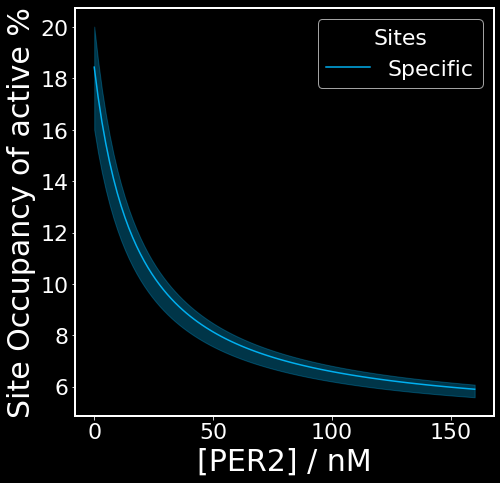

In [76]:
plt.plot(PER2s, 100*Y_PER2_2s[:, var['CBS']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(PER2s, 100*Y_PER2_3s[:, var['CBS']]/S3, 100*Y_PER2_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Site Occupancy of active %')

medium_size = 22
large_size = 30
#plt.xlim([0, 20])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

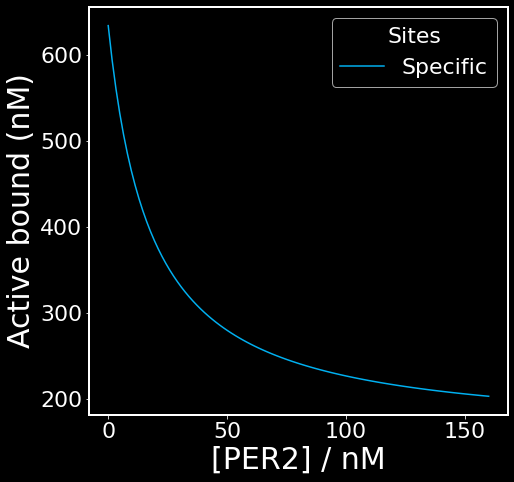

In [78]:
plt.plot(PER2s, 1E-9 *(N_A * V) * Y_PER2_2s[:, var['CBS']], color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Active bound (nM)')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

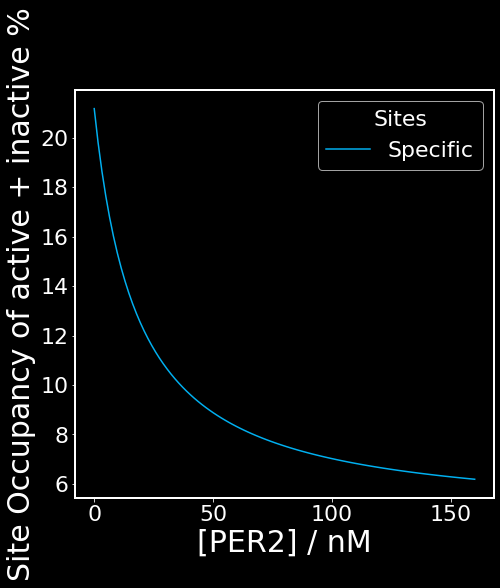

In [79]:
plt.plot(PER2s, 100*(Y_PER2_2s[:, var['CBS']] + Y_PER2_2s[:, var['CBC1S']])/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Site Occupancy of active + inactive %')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

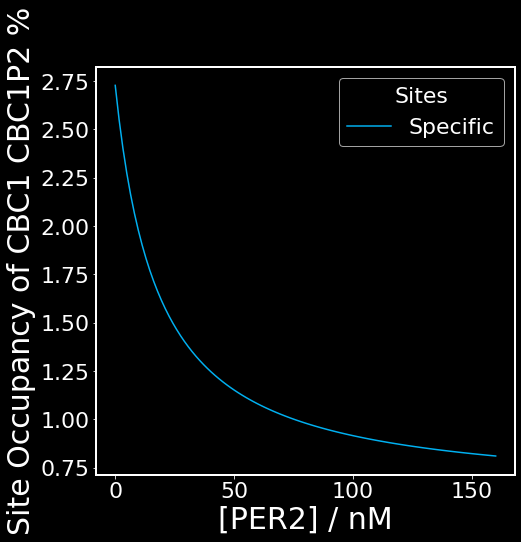

In [80]:
plt.plot(PER2s, 100*(Y_PER2_2s[:, var['CBC1P2S']] + Y_PER2_2s[:, var['CBC1S']])/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Site Occupancy of CBC1 CBC1P2 %')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

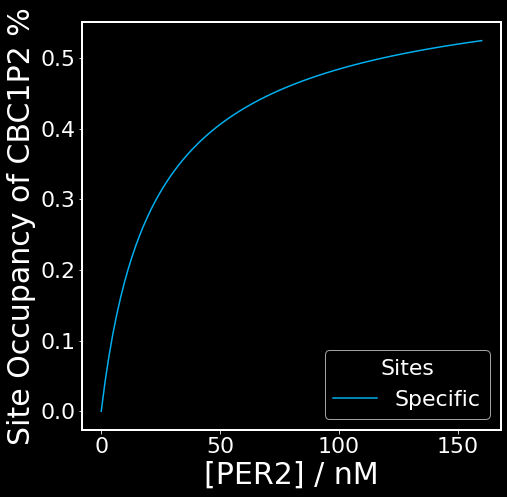

In [81]:
plt.plot(PER2s, 100*(Y_PER2_2s[:, var['CBC1P2S']])/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Site Occupancy of CBC1P2 %')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

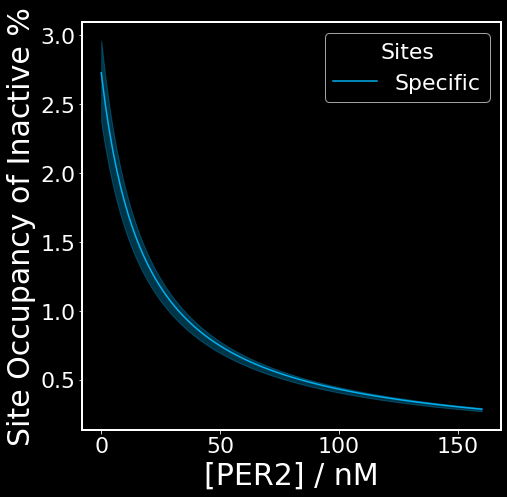

In [82]:
plt.plot(PER2s, 100*Y_PER2_2s[:, var['CBC1S']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(PER2s, 100*Y_PER2_3s[:, var['CBC1S']]/S3, 100*Y_PER2_1s[:, var['CBC1S']]/S1, color=(0/255, 176/255, 240/255, 0.3))
plt

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Site Occupancy of Inactive %')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

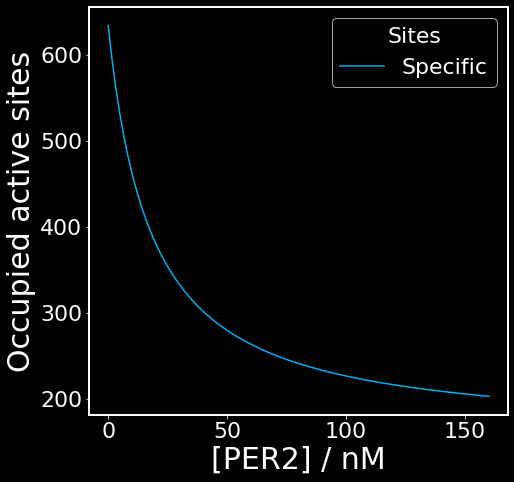

In [83]:
plt.plot(PER2s, Y_PER2_2s[:, var['CBS']]*(1E-9*N_A*V), color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Occupied active sites')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

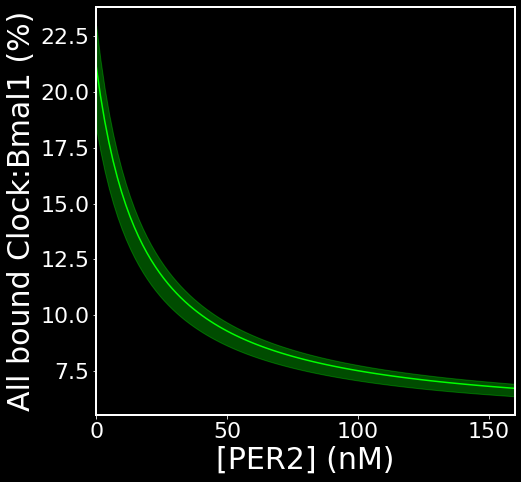

In [84]:
specifics = Y_PER2_2s[:, var['CBS']] + Y_PER2_2s[:, var['CBC1S']] + Y_PER2_2s[:, var['CBC1P2S']] # 
specifics1 = Y_PER2_1s[:, var['CBS']] + Y_PER2_1s[:, var['CBC1S']] + Y_PER2_1s[:, var['CBC1P2S']]
specifics3 = Y_PER2_3s[:, var['CBS']] + Y_PER2_3s[:, var['CBC1S']] + Y_PER2_3s[:, var['CBC1P2S']]


plt.plot(PER2s, 100*specifics/S2, color=(0/255, 255/255, 0/255, 1), label='All')
plt.fill_between(PER2s, 100*specifics3/S3, 100*specifics1/S1, color=(0/255, 255/255, 0/255, 0.3))



plt.xlabel('[PER2] (nM)')
plt.ylabel('All bound Clock:Bmal1 (%)')

medium_size = 22
large_size = 30
plt.xlim([0, 160])
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
#plt.savefig('Outputs/All specific bound CB species over PER2.svg', transparent=True, format='svg', bbox_inches='tight')

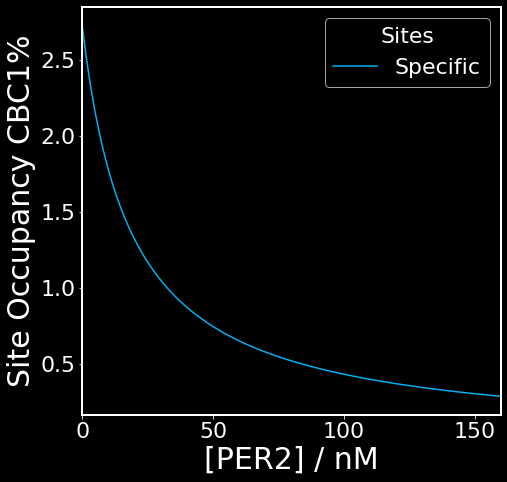

In [85]:
specifics = Y_PER2_2s[:, var['CBC1S']]
plt.plot(PER2s, 100*specifics/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('[PER2] / nM')
plt.ylabel('Site Occupancy CBC1%')

medium_size = 22
large_size = 30
plt.xlim([0, 160])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

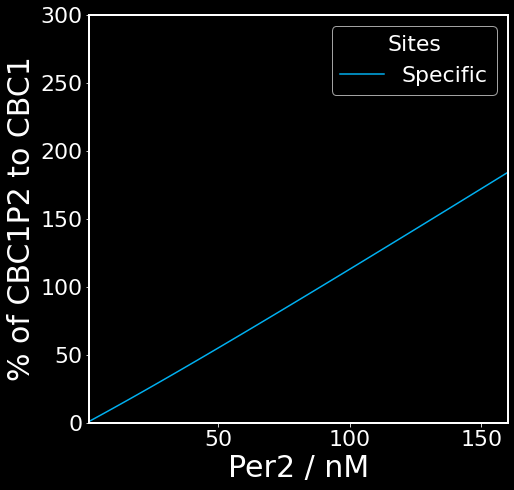

In [86]:
frac = 100 * Y_PER2_2s[:, var['CBC1P2']] / Y_PER2_2s[:, var['CBC1']]

plt.plot(PER2s, frac, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('Per2 / nM')
plt.ylabel('% of CBC1P2 to CBC1')

medium_size = 22
large_size = 30
plt.xlim([1, 160])
plt.ylim([0, 300])
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

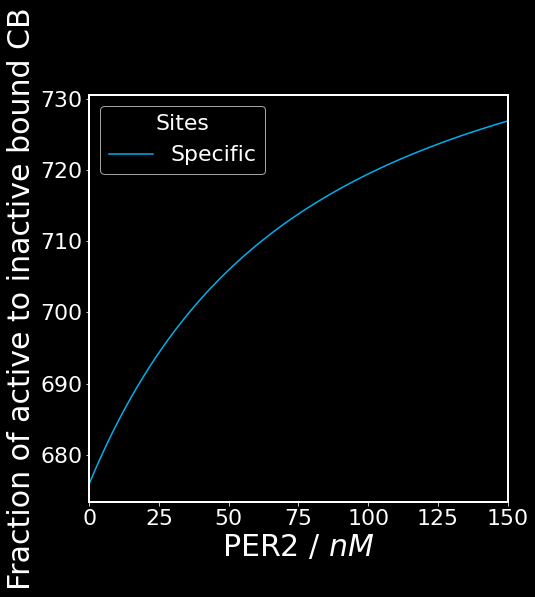

In [87]:
specific = Y_PER2_2s[:, var['CBS']]  / (Y_PER2_2s[:, var['CBC1S']] + Y_PER2_2s[:, var['CBC1P2S']])
plt.plot(PER2s, 100*specific, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('PER2 / $nM$')
plt.ylabel('Fraction of active to inactive bound CB')

medium_size = 22
large_size = 30
plt.xlim([0, 150])
#plt.xscale('log')
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

In [88]:
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c OAT outputs", 'Per2 OAT.csv'), 
           np.array([CRY1s, 
                     100*Y_PER2_3s[:, var['CBS']]/S3, 
                     100*Y_PER2_2s[:, var['CBS']]/S2,
                     100*Y_PER2_1s[:, var['CBS']]/S1]).transpose(), 
           delimiter=',', 
           header='PER2 (nM), SO lower bound (%), SO mean (%), SO upper bound (%)')

In [112]:
samples = 100

initial_concentrations = np.array([np.array([0.0]*14)]*samples)

Ss = np.logspace(0, 4, num=samples)
initial_concentrations[:, var['S']] = Ss * 1E9 / (N_A * V)
initial_concentrations[:, var['B']] = Bmal1(tps)[TP] # np.mean(Bmal1(tps))# 
initial_concentrations[:, var['C']] = Clock[TP] # np.mean(Clock) # 
initial_concentrations[:, var['P2']] =  Per2(tps)[TP] # np.mean(Per2(tps)) #
initial_concentrations[:, var['C1']] = Cry1(tps)[TP] # Cry1(tps)[TP] # 

k_on = fitted_params[0] # 6.09958629e-01
k_off_star = CB_EBOX_Kd * k_on
d_on = fitted_params[1] # 7.77793404e-01
d_off = kd_CB_C1s(tps)[TP] * d_on # np.mean(kd_CB_C1s(tps)) * d_on # 
a_on = fitted_params[2] # 5.61745347e-01
a_off = kd_C1_P2 * a_on
R_on = fitted_params[3] # 1.79972287e-02 # from model A fitting #k_on
R_off = fitted_params[4] # 3.84000082e+00 # from model A fitting #4.41331323e+01
b_on = fitted_params[5] #8.16182898e-03
b_off = kd_CB * b_on
        
k_ons = np.array([k_on] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')
            
Y_Ss = ODE_limit(initial_concentrations, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_CRY1_1s)
#np.savetxt

100%|██████████| 100/100 [00:03<00:00, 32.41it/s]

Max Percentage difference over the last 200 points = 0.00


In [125]:
k_off_star = CB_EBOX_Kd * k_on
k_off_star

0.2684237

In [128]:
(3436 * 1E9 / (N_A * V))

6.161046970595631

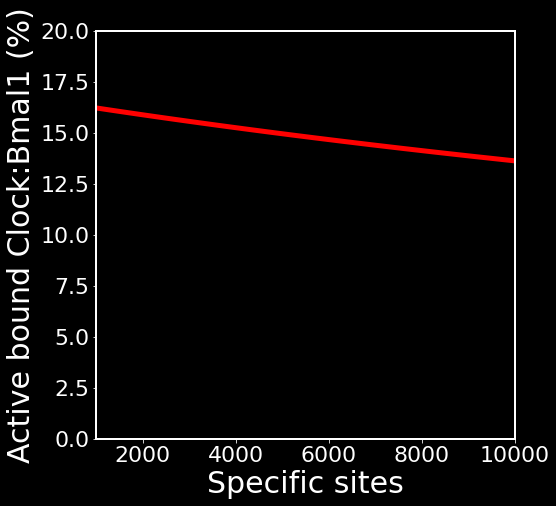

In [126]:
plt.plot(Ss, 100*Y_Ss[:, var['CBS']]/(Ss * 1E9 / (N_A * V)), color=red, label='Active', linewidth=5)

plt.xlabel('Specific sites')
plt.ylabel('Active bound Clock:Bmal1 (%)')

medium_size = 22
large_size = 30
plt.xlim([1000, 10000])
plt.ylim([0, 20])
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

#plt.savefig('Outputs/All specific bound CB species over CRY1.svg', transparent=True, format='svg', bbox_inches='tight')

In [129]:
100*Y_Ss[:, var['CBS']]/(Ss * 1E9 / (N_A * V))

array([16.5798427 , 16.57980787, 16.57976964, 16.57972768, 16.57968163,
       16.5796311 , 16.57957563, 16.57951476, 16.57944796, 16.57937464,
       16.57929417, 16.57920586, 16.57910894, 16.57900258, 16.57888584,
       16.57875771, 16.57861711, 16.5784628 , 16.57829344, 16.57810758,
       16.5779036 , 16.57767973, 16.57743406, 16.57716443, 16.57686852,
       16.57654378, 16.57618738, 16.57579626, 16.57536702, 16.57489596,
       16.574379  , 16.57381167, 16.57318912, 16.57250581, 16.57175603,
       16.5709332 , 16.57003024, 16.56903936, 16.56795199, 16.56675877,
       16.5654494 , 16.5640126 , 16.56243599, 16.56070601, 16.55880775,
       16.55672491, 16.55443958, 16.55193213, 16.54918107, 16.5461628 ,
       16.5428515 , 16.53921883, 16.53523376, 16.53086231, 16.52606723,
       16.52080776, 16.51503924, 16.50871281, 16.501775  , 16.49416729,
       16.48582571, 16.47668028, 16.46665456, 16.45566503, 16.44362047,
       16.43042135, 16.4159591 , 16.40011535, 16.38276117, 16.36

In [121]:
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c OAT outputs", 'Sites OAT.csv'), 
           np.array([Ss, 
                     100*Y_Ss[:, var['CBS']]/(Ss * 1E9 / (N_A * V))]).transpose(), 
           delimiter=',', 
           header='Sites, SO (%)')

In [89]:
samples = 100

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['B']] = Bmal1(tps)[TP] # np.mean(Bmal1(tps))# 
initial_concentrations1[:, var['C']] = Clock[TP] # np.mean(Clock) # 
initial_concentrations1[:, var['P2']] =  Per2(tps)[TP] # np.mean(Per2(tps)) #
#initial_concentrations1[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['B']] = Bmal1(tps)[TP] # np.mean(Bmal1(tps))# 
initial_concentrations2[:, var['C']] =  Clock[TP] # np.mean(Clock) #
initial_concentrations2[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
#initial_concentrations2[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['B']] = Bmal1(tps)[TP] # np.mean(Bmal1(tps))# 
initial_concentrations3[:, var['C']] = Clock[TP] # np.mean(Clock) # 
initial_concentrations3[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
#initial_concentrations3[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

CRY1s = np.linspace(0, 160, num=samples)
initial_concentrations1[:, var['C1']] = CRY1s
initial_concentrations2[:, var['C1']] = CRY1s
initial_concentrations3[:, var['C1']] = CRY1s

k_on = fitted_params[0] # 6.09958629e-01
k_off_star = CB_EBOX_Kd * k_on
d_on = fitted_params[1] # 7.77793404e-01
d_off = kd_CB_C1s(tps)[TP] * d_on # np.mean(kd_CB_C1s(tps)) * d_on # 
a_on = fitted_params[2] # 5.61745347e-01
a_off = kd_C1_P2 * a_on
R_on = fitted_params[3] # 1.79972287e-02 # from model A fitting #k_on
R_off = fitted_params[4] # 3.84000082e+00 # from model A fitting #4.41331323e+01
b_on = fitted_params[5] #8.16182898e-03
b_off = kd_CB * b_on
        
k_ons = np.array([k_on] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')
            
Y_CRY1_1s = ODE_limit(initial_concentrations1, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_CRY1_2s = ODE_limit(initial_concentrations2, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_CRY1_3s = ODE_limit(initial_concentrations3, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_CRY1_1s)
#np.savetxt

  3%|▎         | 3/100 [00:00<00:03, 29.86it/s]

Max Percentage difference over the last 200 points = 0.00


  3%|▎         | 3/100 [00:00<00:03, 27.55it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 100/100 [00:04<00:00, 24.22it/s]

Max Percentage difference over the last 200 points = 0.00


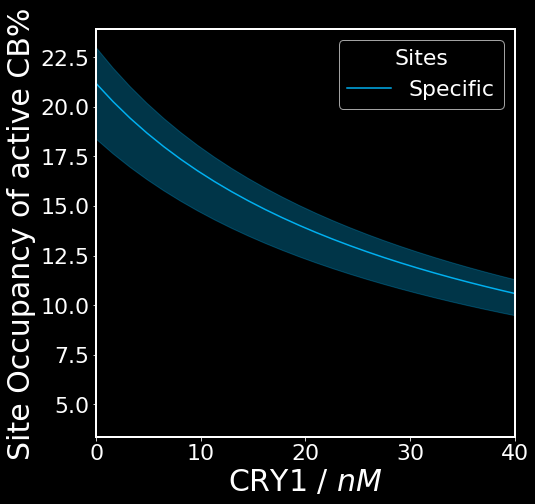

In [97]:
plt.plot(CRY1s, 100*Y_CRY1_2s[:, var['CBS']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(CRY1s, 100*Y_CRY1_3s[:, var['CBS']]/S3, 100*Y_CRY1_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1 / $nM$')
plt.ylabel('Site Occupancy of active CB%')

medium_size = 22
large_size = 30
plt.xlim([0, 40])
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

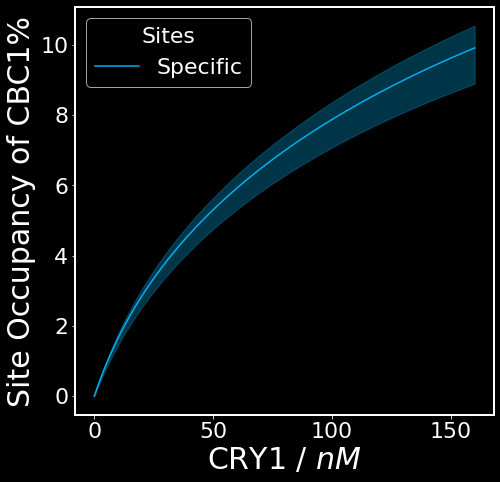

In [91]:
plt.plot(CRY1s, 100*Y_CRY1_2s[:, var['CBC1S']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(CRY1s, 100*Y_CRY1_3s[:, var['CBC1S']]/S3, 100*Y_CRY1_1s[:, var['CBC1S']]/S1, color=(0/255, 176/255, 240/255, 0.3))

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1 / $nM$')
plt.ylabel('Site Occupancy of CBC1%')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

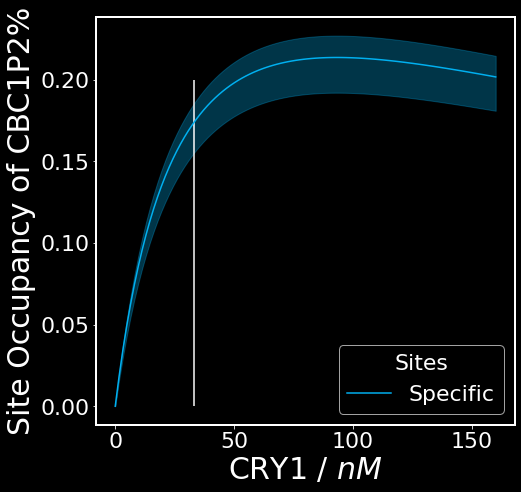

In [94]:
plt.plot(CRY1s, 100*Y_CRY1_2s[:, var['CBC1P2S']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(CRY1s, 100*Y_CRY1_3s[:, var['CBC1P2S']]/S3, 100*Y_CRY1_1s[:, var['CBC1P2S']]/S1, color=(0/255, 176/255, 240/255, 0.3))
plt.vlines(Bmal1(tps)[TP], 0, 0.2, color='w')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1 / $nM$')
plt.ylabel('Site Occupancy of CBC1P2%')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

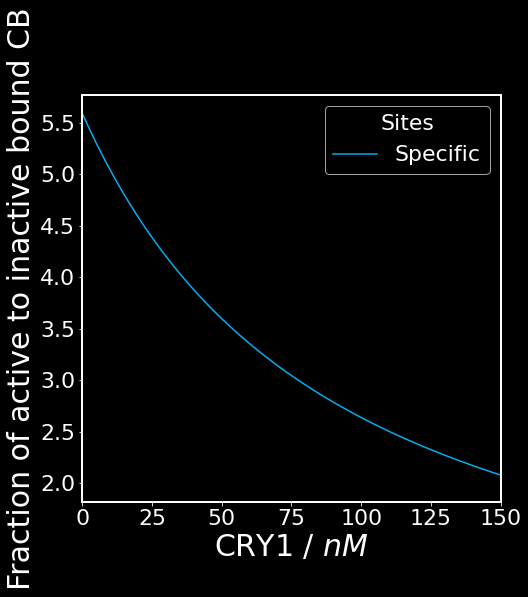

In [95]:
specific = Y_CRY1_2s[:, var['CBC1P2S']] / (Y_CRY1_2s[:, var['CBC1S']] + Y_CRY1_2s[:, var['CBC1P2S']])
plt.plot(CRY1s, 100*specific, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1 / $nM$')
plt.ylabel('Fraction of active to inactive bound CB')

medium_size = 22
large_size = 30
plt.xlim([0, 150])
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

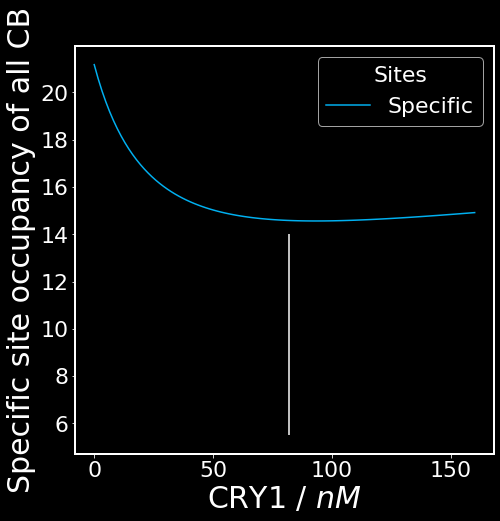

In [98]:
specific = Y_CRY1_2s[:, var['CBS']] + (Y_CRY1_2s[:, var['CBC1S']] + Y_CRY1_2s[:, var['CBC1P2S']])
plt.plot(CRY1s, 100*specific/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.vlines(82, 5.5, 14,  color='w')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1 / $nM$')
plt.ylabel('Specific site occupancy of all CB')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

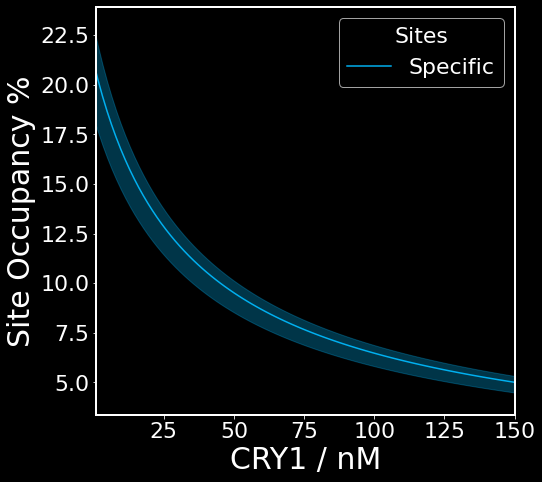

In [99]:
plt.plot(CRY1s, 100*Y_CRY1_2s[:, var['CBS']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(PER2s, 100*Y_CRY1_3s[:, var['CBS']]/S3, 100*Y_CRY1_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))


plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1 / nM')
plt.ylabel('Site Occupancy %')

medium_size = 22
large_size = 30
plt.xlim([1, 150])
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

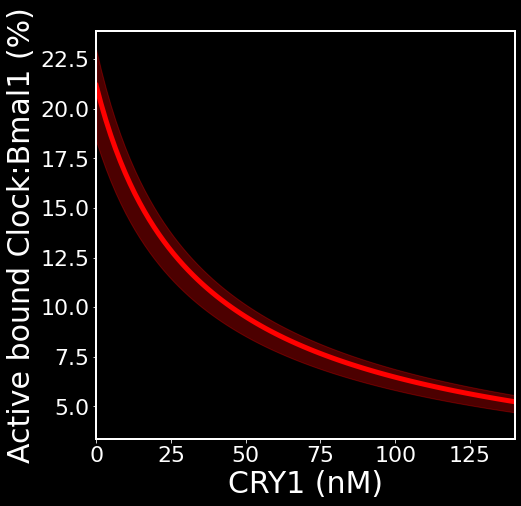

In [100]:
c1_specifics = Y_CRY1_2s[:, var['CBS']] + Y_CRY1_2s[:, var['CBC1S']] + Y_CRY1_2s[:, var['CBC1P2S']] # 
c1_specifics1 = Y_CRY1_1s[:, var['CBS']] + Y_CRY1_1s[:, var['CBC1S']] + Y_CRY1_1s[:, var['CBC1P2S']]
c1_specifics3 = Y_CRY1_3s[:, var['CBS']] + Y_CRY1_3s[:, var['CBC1S']] + Y_CRY1_3s[:, var['CBC1P2S']]

c1_inactive_specifics = Y_CRY1_2s[:, var['CBC1S']] + Y_CRY1_2s[:, var['CBC1P2S']] # 
c1_inactive_specifics1 = Y_CRY1_1s[:, var['CBC1S']] + Y_CRY1_1s[:, var['CBC1P2S']]
c1_inactive_specifics3 = Y_CRY1_3s[:, var['CBC1S']] + Y_CRY1_3s[:, var['CBC1P2S']]

c1_active_specifics = Y_CRY1_2s[:, var['CBS']]# 
c1_active_specifics1 = Y_CRY1_1s[:, var['CBS']] 
c1_active_specifics3 = Y_CRY1_3s[:, var['CBS']] 


plt.plot(CRY1s, 100*c1_active_specifics/S2, color=red, label='Active', linewidth=5)
plt.fill_between(CRY1s, 100*c1_active_specifics3/S3, 100*c1_active_specifics1/S1, color=(255/255, 0, 0, 0.3))

plt.xlabel('CRY1 (nM)')
plt.ylabel('Active bound Clock:Bmal1 (%)')

medium_size = 22
large_size = 30
plt.xlim([0, 140])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

#plt.savefig('Outputs/All specific bound CB species over CRY1.svg', transparent=True, format='svg', bbox_inches='tight')

In [101]:
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c OAT outputs", 'Cry1 OAT.csv'), 
           np.array([CRY1s, 
                     100*Y_CRY1_3s[:, var['CBS']]/S3, 
                     100*Y_CRY1_2s[:, var['CBS']]/S2,
                     100*Y_CRY1_1s[:, var['CBS']]/S1]).transpose(), 
           delimiter=',', 
           header='CRY1 (nM), SO lower bound (%), SO mean (%), SO upper bound (%)')

In [102]:
samples = 500

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
#initial_concentrations1[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
#initial_concentrations1[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations1[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
initial_concentrations1[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

initial_concentrations2[:, var['S']] = S2
#initial_concentrations2[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
#initial_concentrations2[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations2[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
initial_concentrations2[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

initial_concentrations3[:, var['S']] = S3
#initial_concentrations3[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
#initial_concentrations3[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations3[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
initial_concentrations3[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

CBs = np.linspace(0, 1000, num=samples)
initial_concentrations1[:, var['B']] = CBs
initial_concentrations1[:, var['C']] = CBs / bmal1_to_clock_ratio

initial_concentrations2[:, var['B']] = CBs
initial_concentrations2[:, var['C']] = CBs / bmal1_to_clock_ratio

initial_concentrations3[:, var['B']] = CBs
initial_concentrations3[:, var['C']] = CBs / bmal1_to_clock_ratio

k_on = fitted_params[0] # 6.09958629e-01
k_off_star = CB_EBOX_Kd * k_on
d_on = fitted_params[1] # 7.77793404e-01
d_off = kd_CB_C1s(tps)[TP] * d_on # np.mean(kd_CB_C1s(tps)) * d_on # 
a_on = fitted_params[2] # 5.61745347e-01
a_off = kd_C1_P2 * a_on
R_on = fitted_params[3] # 1.79972287e-02 # from model A fitting #k_on
R_off = fitted_params[4] # 3.84000082e+00 # from model A fitting #4.41331323e+01
b_on = fitted_params[5] #8.16182898e-03
b_off = kd_CB * b_on

k_ons = np.array([k_on] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')

Y_CB_1s = ODE_limit(initial_concentrations1, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_CB_2s = ODE_limit(initial_concentrations2, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_CB_3s = ODE_limit(initial_concentrations3, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_CB_1s)
#np.savetxt

  1%|          | 4/500 [00:00<00:14, 34.92it/s]

Max Percentage difference over the last 200 points = 0.00


 79%|███████▉  | 395/500 [00:15<00:04, 23.08it/s]/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
  1%|          | 4/500 [00:00<00:13, 37.68it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 500/500 [00:19<00:00, 25.66it/s]


Max Percentage difference over the last 200 points = 0.00


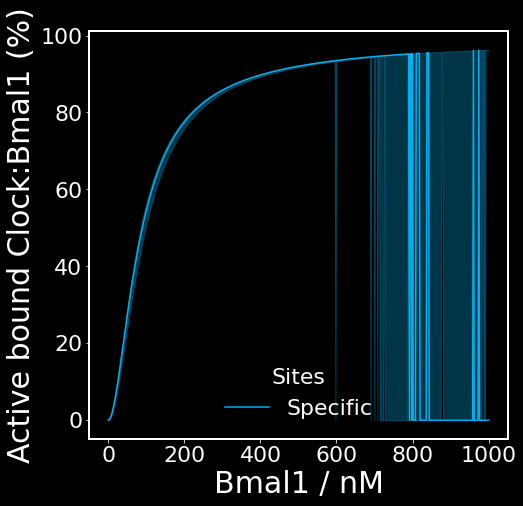

In [103]:
cb_specifics = Y_CB_2s[:, var['CBS']] + Y_CB_2s[:, var['CBC1S']] + Y_CB_2s[:, var['CBC1P2S']] # 
cb_specifics1 = Y_CB_1s[:, var['CBS']] + Y_CB_1s[:, var['CBC1S']] + Y_CB_1s[:, var['CBC1P2S']]
cb_specifics3 = Y_CB_3s[:, var['CBS']] + Y_CB_3s[:, var['CBC1S']] + Y_CB_3s[:, var['CBC1P2S']]


plt.plot(CBs, 100*Y_CB_2s[:, var['CBS']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(CBs, 100*Y_CB_3s[:, var['CBS']]/S3, 100*Y_CB_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))

leg = plt.legend(title='Sites', title_fontsize=medium_size, facecolor=(0, 0, 0, 0))#, loc=)
leg.get_frame().set_alpha(0)

plt.xlabel('Bmal1 / nM')
plt.ylabel('Active bound Clock:Bmal1 (%)')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
#plt.savefig('Outputs/spefic site occupancy as a function of CB.svg', transparent=True, format='svg', bbox_inches='tight')

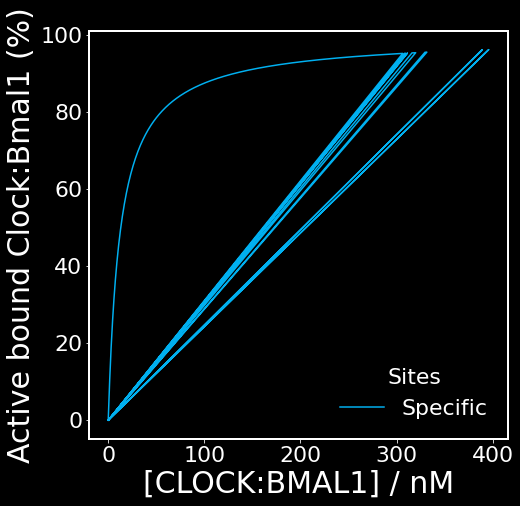

In [104]:

plt.plot(Y_CB_2s[:, var['CB']], 100*Y_CB_2s[:, var['CBS']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
#plt.fill_between(CBs, 100*Y_CB_3s[:, var['CBS']]/S3, 100*Y_CB_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))
#plt.fill_between(CBs, 100*Y_CB_3s[:, var['CBN']]/N, 100*Y_CB_1s[:, var['CBN']]/N, color=(255/255, 192/255, 0, 0.3))

leg = plt.legend(title='Sites', title_fontsize=medium_size, facecolor=(0, 0, 0, 0))#, loc=)
leg.get_frame().set_alpha(0)

plt.xlabel('[CLOCK:BMAL1] / nM')
plt.ylabel('Active bound Clock:Bmal1 (%)')

medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
#plt.savefig('Outputs/spefic site occupancy as a function of CB.svg', transparent=True, format='svg', bbox_inches='tight')

In [105]:
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c OAT outputs/", 'Clock Bmal1 OAT.csv'), 
           np.array([CBs, 
                     Y_CB_2s[:, var['CB']],
                     100*Y_CB_3s[:, var['CBS']]/S3, 
                     100*Y_CB_2s[:, var['CBS']]/S2,
                     100*Y_CB_1s[:, var['CBS']]/S1]).transpose(), 
           delimiter=',', 
           header='BMAL1 (nM), CLOCK:BMAL1 (nM), SO lower bound (%), SO mean (%), SO upper bound (%)')

In [106]:
samples = 500

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['B']] =  Bmal1(tps)[TP] # np.mean(Bmal1(tps))# 
initial_concentrations1[:, var['C']] =  Clock[TP] # np.mean(Clock) # 
initial_concentrations1[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
initial_concentrations1[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['B']] =  Bmal1(tps)[TP] # np.mean(Bmal1(tps))#
initial_concentrations2[:, var['C']] =  Clock[TP] # np.mean(Clock) # 
initial_concentrations2[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
initial_concentrations2[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['B']] =  Bmal1(tps)[TP] # np.mean(Bmal1(tps))#
initial_concentrations3[:, var['C']] =  Clock[TP] # np.mean(Clock) # 
initial_concentrations3[:, var['P2']] = Per2(tps)[TP] # np.mean(Per2(tps)) # 
initial_concentrations3[:, var['C1']] = Cry1(tps)[TP] # np.mean(Cry1(tps)) # 

k_on = fitted_params[0] # 6.09958629e-01
k_off_star = CB_EBOX_Kd * k_on
d_on = fitted_params[1] # 7.77793404e-01
d_off = kd_CB_C1s(tps)[TP] * d_on # np.mean(kd_CB_C1s(tps)) * d_on # 
a_on = fitted_params[2] # 5.61745347e-01
a_off = kd_C1_P2 * a_on
R_on = fitted_params[3] # 1.79972287e-02 # from model A fitting #k_on
R_off = fitted_params[4] # 3.84000082e+00 # from model A fitting #4.41331323e+01
b_on = fitted_params[5] #8.16182898e-03
b_off = kd_CB * b_on

k_ons = np.array([k_on] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')

k_off_stars_kOFF_OAT = np.logspace(-3, 3, num=samples)

Y_kOFF_1s = ODE_limit(initial_concentrations1, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars_kOFF_OAT, b_ons, b_offs)
Y_kOFF_2s = ODE_limit(initial_concentrations2, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars_kOFF_OAT, b_ons, b_offs)
Y_kOFF_3s = ODE_limit(initial_concentrations3, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars_kOFF_OAT, b_ons, b_offs)
#print(Y_kOFF_1s)
#np.savetxt

  0%|          | 0/500 [00:00<?, ?it/s]

Max Percentage difference over the last 200 points = 0.00


  0%|          | 0/500 [00:00<?, ?it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 500/500 [00:17<00:00, 29.20it/s]


Max Percentage difference over the last 200 points = 0.00


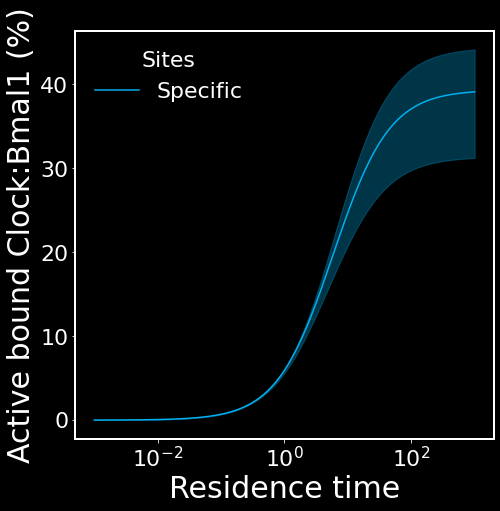

In [107]:
plt.plot(1/k_off_stars_kOFF_OAT, 100*Y_kOFF_2s[:, var['CBS']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(1/k_off_stars_kOFF_OAT, 100*Y_kOFF_3s[:, var['CBS']]/S3, 100*Y_kOFF_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))
#plt.vlines(1/kOFF, 0, 100, color='w')
#plt.vlines(40, 0, 100, color='r')

leg = plt.legend(title='Sites', title_fontsize=medium_size, facecolor=(0, 0, 0, 0))#, loc=)
leg.get_frame().set_alpha(0)

plt.xlabel('Residence time')
plt.ylabel('Active bound Clock:Bmal1 (%)')

medium_size = 22
large_size = 30
plt.xscale('log')
#plt.xlim([0, 5])
#plt.ylim([0, 20])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
#plt.savefig('Outputs/spefic site occupancy as a function of CB.svg', transparent=True, format='svg', bbox_inches='tight')

In [108]:
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c OAT outputs/", 'Residence time OAT.csv'), 
           np.array([1/k_off_stars_kOFF_OAT, 
                     100*Y_kOFF_3s[:, var['CBS']]/S3, 
                     100*Y_kOFF_2s[:, var['CBS']]/S2,
                     100*Y_kOFF_1s[:, var['CBS']]/S1]).transpose(), 
           delimiter=',', 
           header='Residence time (s), SO lower bound (%), SO mean (%), SO upper bound (%)')

In [63]:
Y_kOFF_2s[0, var['CB']] * 1e-9 * (N_A * V)

743.0483244833758

In [64]:
Y_kOFF_2s[-1, var['CB']] * 1e-9 * (N_A * V)

837.8649988490864

In [65]:
100*Y_kOFF_2s[0, var['CBS']]/S2

14.769823980493438

In [66]:
100*Y_kOFF_2s[0, var['CBC1S']]/S2

2.3476141663558003

In [67]:
100*Y_kOFF_2s[0, var['CBC1P2S']]/S2

0.13601325579086743

In [70]:
100*Y_kOFF_C1P2_2s[0, var['CBS']]/S2

11.340990625551152

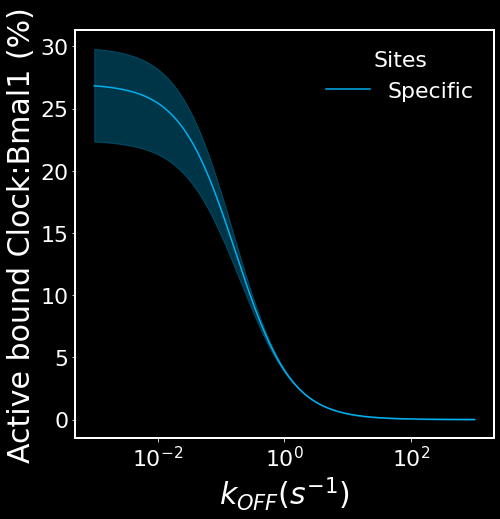

In [68]:
cb_specifics = Y_kOFF_2s[:, var['CBS']] + Y_kOFF_2s[:, var['CBC1S']] + Y_kOFF_2s[:, var['CBC1P2S']] # 
cb_specifics1 = Y_kOFF_2s[:, var['CBS']] + Y_kOFF_1s[:, var['CBC1S']] + Y_kOFF_1s[:, var['CBC1P2S']]
cb_specifics3 = Y_kOFF_3s[:, var['CBS']] + Y_kOFF_3s[:, var['CBC1S']] + Y_kOFF_3s[:, var['CBC1P2S']]


plt.plot(k_off_stars_kOFF_OAT, 100*Y_kOFF_2s[:, var['CBS']]/S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(k_off_stars_kOFF_OAT, 100*Y_kOFF_3s[:, var['CBS']]/S3, 100*Y_kOFF_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))

leg = plt.legend(title='Sites', title_fontsize=medium_size, facecolor=(0, 0, 0, 0))#, loc=)
leg.get_frame().set_alpha(0)

plt.xlabel(r'$k_{OFF} (s^{-1})$')
plt.ylabel('Active bound Clock:Bmal1 (%)')

medium_size = 22
large_size = 30
plt.xscale('log')
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
#plt.savefig('Outputs/spefic site occupancy as a function of CB.svg', transparent=True, format='svg', bbox_inches='tight')

In [69]:
samples = 100

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations1[:, var['C']] = np.mean(Clock) # Clock[TP] # 
#initial_concentrations1[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
#initial_concentrations1[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations2[:, var['C']] = np.mean(Clock) # Clock[TP] # 
#initial_concentrations2[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
#initial_concentrations2[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations3[:, var['C']] = np.mean(Clock) # Clock[TP] # 
#initial_concentrations3[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
#initial_concentrations3[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

Cry1_Per2s = np.linspace(0, 120, num=samples)
initial_concentrations1[:, var['C1']] = Cry1_Per2s
initial_concentrations2[:, var['C1']] = Cry1_Per2s
initial_concentrations3[:, var['C1']] = Cry1_Per2s

initial_concentrations1[:, var['P2']] = Cry1_Per2s
initial_concentrations2[:, var['P2']] = Cry1_Per2s
initial_concentrations3[:, var['P2']] = Cry1_Per2s

k_on = fitted_params[0] # 6.09958629e-01
k_off_star = CB_EBOX_Kd * k_on
d_on = fitted_params[1] # 7.77793404e-01
d_off = kd_CB_C1s(tps)[TP] * d_on # np.mean(kd_CB_C1s(tps)) * d_on # 
a_on = fitted_params[2] # 5.61745347e-01
a_off = kd_C1_P2 * a_on
R_on = fitted_params[3] # 1.79972287e-02 # from model A fitting #k_on
R_off = fitted_params[4] # 3.84000082e+00 # from model A fitting #4.41331323e+01
b_on = fitted_params[5] #8.16182898e-03
b_off = kd_CB * b_on

k_ons = np.array([k_on] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')

Y_C1_P2_1s = ODE_limit(initial_concentrations1, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_C1_P2_2s = ODE_limit(initial_concentrations2, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_C1_P2_3s = ODE_limit(initial_concentrations3, t_long, k_ons, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_C1_P2_1s)
#np.savetxt

  3%|▎         | 3/100 [00:00<00:03, 27.66it/s]

Max Percentage difference over the last 200 points = 0.00


  3%|▎         | 3/100 [00:00<00:03, 29.06it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 100/100 [00:03<00:00, 30.53it/s]

Max Percentage difference over the last 200 points = 0.00


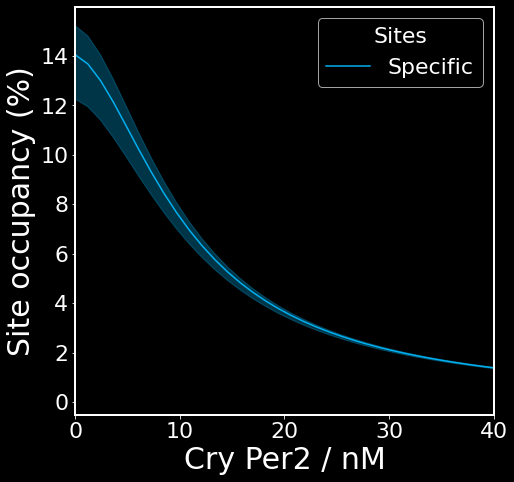

In [70]:

plt.plot(Cry1_Per2s, 100 * Y_C1_P2_2s[:, var['CBS']] / S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(Cry1_Per2s, 100*Y_C1_P2_3s[:, var['CBS']]/S3, 100*Y_C1_P2_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('Cry Per2 / nM')
plt.ylabel('Site occupancy (%)')

medium_size = 22
large_size = 30
plt.xlim([0, 40])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

## Figure S8 B CRY1 PER2 OAT for kOFF

In [64]:
samples = 500

TP = 4 # T40 timepoint

Cry1_Per2s = np.linspace(0, 1000, num=samples)

initial_concentrations_1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_1[:, var['S']] = S1
initial_concentrations_1[:, var['B']] = Bmal1(tps)[TP]
initial_concentrations_1[:, var['C']] = Clock[TP]
initial_concentrations_1[:, var['C1']] = Cry1_Per2s
initial_concentrations_1[:, var['P2']] = Cry1_Per2s
initial_concentrations_1 = initial_concentrations_1.astype('float64')

ode_model_1 = DNA_binding_model_B1(samples, initial_concentrations_1, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, np.array([kd_CB_C1s(tps)[TP]]*samples), cores=20)

result_1 = ode_model_1.full_simulate(fitted_params)
kOFF__C1P2_sim_1 = result_1[:, 0]
equilibrium_conc_sim_1 = np.array([el[1:] for el in result_1])

initial_concentrations_2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_2[:, var['S']] = S2
initial_concentrations_2[:, var['B']] = Bmal1(tps)[TP]
initial_concentrations_2[:, var['C']] = Clock[TP]
initial_concentrations_2[:, var['C1']] = Cry1_Per2s
initial_concentrations_2[:, var['P2']] = Cry1_Per2s
initial_concentrations_2 = initial_concentrations_2.astype('float64')

ode_model_2 = DNA_binding_model_B1(samples, initial_concentrations_2, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, np.array([kd_CB_C1s(tps)[TP]]*samples), cores=20)

result_2 = ode_model_2.full_simulate(fitted_params)
kOFF__C1P2_sim_2 = result_2[:, 0]
equilibrium_conc_sim_2 = np.array([el[1:] for el in result_2])

initial_concentrations_3 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_3[:, var['S']] = S3
initial_concentrations_3[:, var['B']] = Bmal1(tps)[TP]
initial_concentrations_3[:, var['C']] = Clock[TP]
initial_concentrations_3[:, var['C1']] = Cry1_Per2s
initial_concentrations_3[:, var['P2']] = Cry1_Per2s
initial_concentrations_3 = initial_concentrations_3.astype('float64')

ode_model_3 = DNA_binding_model_B1(samples, initial_concentrations_3, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, np.array([kd_CB_C1s(tps)[TP]]*samples), cores=20)

result_3 = ode_model_3.full_simulate(fitted_params)
kOFF__C1P2_sim_3 = result_3[:, 0]
equilibrium_conc_sim_3 = np.array([el[1:] for el in result_3])

19

In [65]:
all_C1P2s = equilibrium_conc_sim_2[:, var['C1P2']] + equilibrium_conc_sim_2[:, var['BC1P2']] + equilibrium_conc_sim_2[:, var['CBC1P2']] + equilibrium_conc_sim_2[:, var['CBC1P2S']]

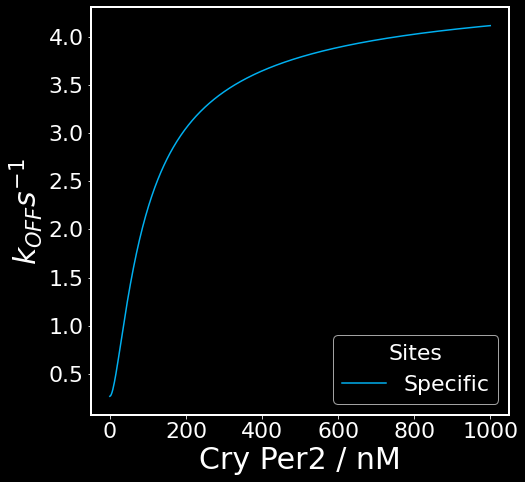

In [66]:
plt.plot(Cry1_Per2s, kOFF__C1P2_sim_2, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('Cry Per2 / nM')
plt.ylabel(r'$k_{OFF} s^{-1}$')
#plt.xscale('log')
medium_size = 22
large_size = 30
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

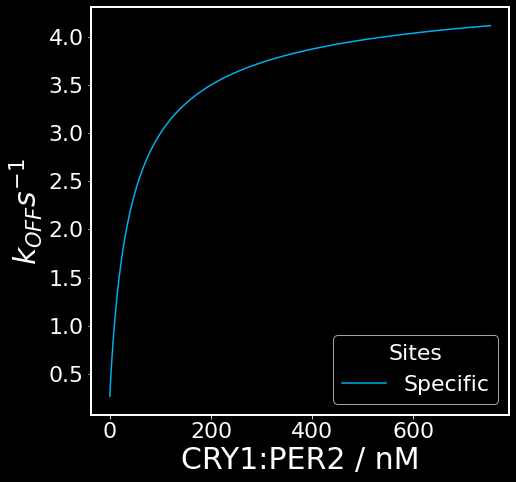

In [68]:
plt.plot(all_C1P2s, kOFF__C1P2_sim_2, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1:PER2 / nM')
plt.ylabel(r'$k_{OFF} s^{-1}$')
#plt.xscale('log')
medium_size = 22
large_size = 30
#plt.xlim([0, 40])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

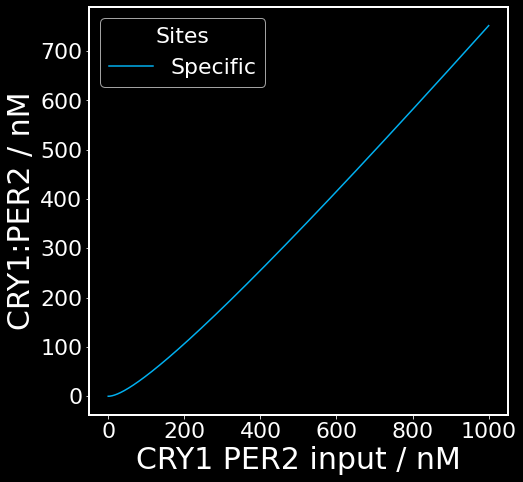

In [70]:
plt.plot(Cry1_Per2s, all_C1P2s, color=(0/255, 176/255, 240/255, 1), label='Specific')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel('CRY1 PER2 input / nM')
plt.ylabel('CRY1:PER2 / nM')
#plt.xscale('log')
medium_size = 22
large_size = 30
#plt.xlim([0, 40])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

In [69]:
np.savetxt(os.path.join("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c OAT outputs/", 'kOFF as a function of CRY1 PER2 OAT.csv'), 
           np.array([Cry1_Per2s, 
                     all_C1P2s,
                     kOFF__C1P2_sim_2]).transpose(), 
           delimiter=',', 
           header='CRY1 PER2 input (nM), all inferred CRY1:PER2 (nM), kOFF (s^-1)')

# Assay the range of each of the fitted params 

k_on = 1.57352e-02 +/- 1.44974e-01 (921.3 %) <br>
k_off = 9.96619e+01 +/- 9.15839e-02 (0.1 %) <br>
d_on = 1.55451e-01 +/- 3.70246e-02 (23.8 %) <br>
a_on = 9.68667e-01 +/- 5.66799e-02 (5.9 %) <br>
R_on = 1.41286e-03 +/- 4.44819e-02 (3148.4 %) <br>
R_off = 1.48733e+01 +/- 6.27463e-02 (0.4 %) <br>
b_on = 8.70337e-02 +/- 3.82050e-02 (43.9 %) <br>

In [100]:
fitted_kON_mean = 1.57352e-02
fitted_kON_std = 1.44974e-01

fitted_dON_mean = 1.55451e-01
fitted_dON_std = 3.70246e-02

fitted_RON_mean = 1.41286e-03
fitted_RON_std = 4.44819e-02  

fitted_bON_mean = 8.70337e-02
fitted_bON_std = 3.82050e-02

In [86]:
samples = 500

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['N']] = N
initial_concentrations1[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations1[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations1[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations1[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['N']] = N
initial_concentrations2[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations2[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations2[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations2[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['N']] = N
initial_concentrations3[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations3[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations3[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations3[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

k_ons = np.array([k_on] * samples, dtype='float64')
k_offs = np.array([k_off] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')


k_ON_OAT = np.linspace(0, fitted_kON_mean + fitted_kON_std, num=samples)

Y_kONs_1s = ODE_limit(initial_concentrations1, t_long, k_ON_OAT, k_offs, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_kONs_2s = ODE_limit(initial_concentrations2, t_long, k_ON_OAT, k_offs, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_kONs_3s = ODE_limit(initial_concentrations3, t_long, k_ON_OAT, k_offs, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_kOFF_1s)
#np.savetxt

  1%|          | 3/500 [00:00<00:17, 27.95it/s]

Max Percentage difference over the last 200 points = 0.00


  1%|          | 3/500 [00:00<00:19, 25.54it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 500/500 [00:26<00:00, 18.63it/s]

Max Percentage difference over the last 200 points = 0.00


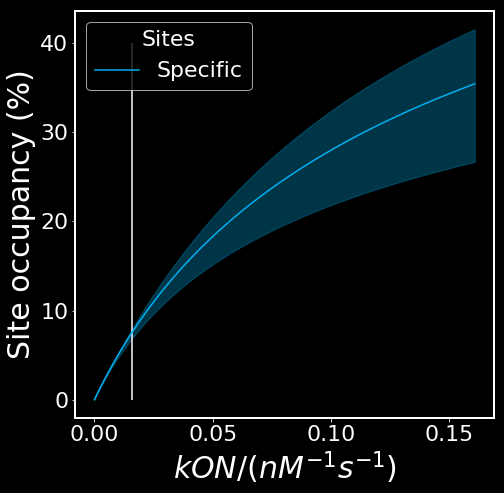

In [92]:
plt.plot(k_ON_OAT, 100 * Y_kONs_2s[:, var['CBS']] / S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(k_ON_OAT, 100*Y_kONs_3s[:, var['CBS']]/S3, 100*Y_kONs_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))
plt.vlines(fitted_kON_mean, 0, 40, color='w')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel(r'$kON / (nM^{-1}s^{-1})$')
plt.ylabel('Site occupancy (%)')

medium_size = 22
large_size = 30
#plt.xlim([0, 40])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

In [101]:
samples = 500

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['N']] = N
initial_concentrations1[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations1[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations1[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations1[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['N']] = N
initial_concentrations2[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations2[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations2[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations2[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['N']] = N
initial_concentrations3[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations3[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations3[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations3[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

k_ons = np.array([k_on] * samples, dtype='float64')
k_offs = np.array([k_off] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')


d_ON_OAT = np.linspace(fitted_dON_mean - fitted_dON_std, fitted_dON_mean + fitted_dON_std, num=samples)

Y_dONs_1s = ODE_limit(initial_concentrations1, t_long, k_ons, k_offs, d_ON_OAT, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_dONs_2s = ODE_limit(initial_concentrations2, t_long, k_ons, k_offs, d_ON_OAT, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_dONs_3s = ODE_limit(initial_concentrations3, t_long, k_ons, k_offs, d_ON_OAT, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_kOFF_1s)
#np.savetxt

  1%|          | 3/500 [00:00<00:22, 22.45it/s]

Max Percentage difference over the last 200 points = 0.00


  0%|          | 0/500 [00:00<?, ?it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 500/500 [00:24<00:00, 20.82it/s]

Max Percentage difference over the last 200 points = 0.00


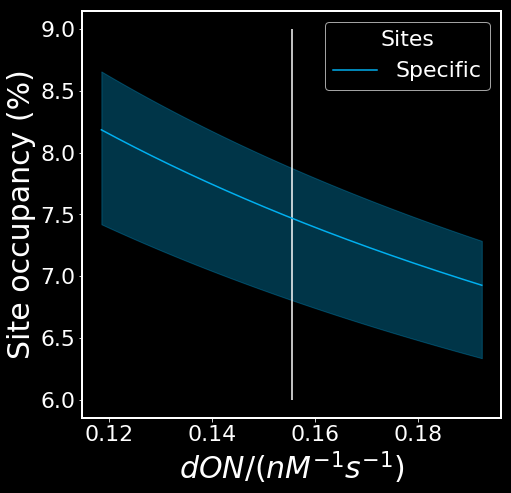

In [104]:
plt.plot(d_ON_OAT, 100 * Y_dONs_2s[:, var['CBS']] / S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(d_ON_OAT, 100*Y_dONs_3s[:, var['CBS']]/S3, 100*Y_dONs_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))
plt.vlines(fitted_dON_mean, 6, 9, color='w')

plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel(r'$dON / (nM^{-1}s^{-1})$')
plt.ylabel('Site occupancy (%)')

medium_size = 22
large_size = 30
#plt.xlim([0, 40])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

In [89]:
samples = 500

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['N']] = N
initial_concentrations1[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations1[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations1[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations1[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['N']] = N
initial_concentrations2[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations2[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations2[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations2[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['N']] = N
initial_concentrations3[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations3[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations3[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations3[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

k_ons = np.array([k_on] * samples, dtype='float64')
k_offs = np.array([k_off] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')


R_ON_OAT = np.linspace(0, fitted_RON_mean + fitted_RON_std, num=samples)

Y_RONs_1s = ODE_limit(initial_concentrations1, t_long, k_ons, k_offs, d_ons, d_offs, R_ON_OAT, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_RONs_2s = ODE_limit(initial_concentrations2, t_long, k_ons, k_offs, d_ons, d_offs, R_ON_OAT, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
Y_RONs_3s = ODE_limit(initial_concentrations3, t_long, k_ons, k_offs, d_ons, d_offs, R_ON_OAT, R_offs, a_ons, a_offs, k_off_stars, b_ons, b_offs)
#print(Y_kOFF_1s)
#np.savetxt

  1%|          | 3/500 [00:00<00:24, 20.08it/s]

Max Percentage difference over the last 200 points = 0.00


  1%|          | 3/500 [00:00<00:24, 20.10it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 500/500 [00:24<00:00, 20.29it/s]

Max Percentage difference over the last 200 points = 0.00


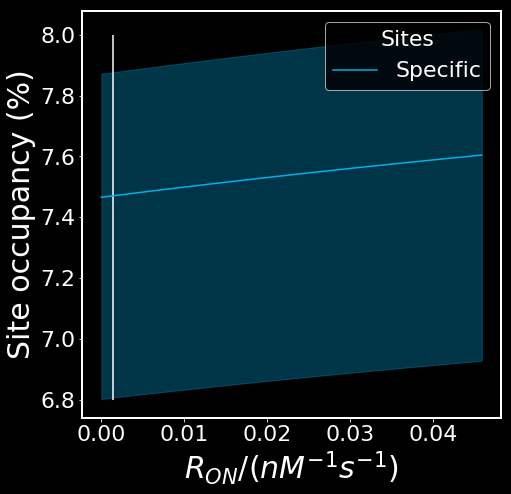

In [95]:
plt.plot(R_ON_OAT, 100 * Y_RONs_2s[:, var['CBS']] / S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(R_ON_OAT, 100*Y_RONs_3s[:, var['CBS']]/S3, 100*Y_RONs_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))
plt.vlines(fitted_RON_mean, 6.8, 8, color='w')
plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel(r'$R_{ON} / (nM^{-1}s^{-1})$')
plt.ylabel('Site occupancy (%)')

medium_size = 22
large_size = 30
#plt.xlim([0, 40])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)

In [98]:
samples = 500

initial_concentrations1 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations2 = np.array([np.array([0.0]*14)]*samples)
initial_concentrations3 = np.array([np.array([0.0]*14)]*samples)

initial_concentrations1[:, var['S']] = S1
initial_concentrations1[:, var['N']] = N
initial_concentrations1[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations1[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations1[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations1[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations2[:, var['S']] = S2
initial_concentrations2[:, var['N']] = N
initial_concentrations2[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations2[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations2[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations2[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

initial_concentrations3[:, var['S']] = S3
initial_concentrations3[:, var['N']] = N
initial_concentrations3[:, var['B']] = np.mean(Bmal1(tps))# Bmal1(tps)[TP] #
initial_concentrations3[:, var['C']] = np.mean(Clock) # Clock[TP] # 
initial_concentrations3[:, var['P2']] = np.mean(Per2(tps)) # Per2(tps)[TP] #
initial_concentrations3[:, var['C1']] = np.mean(Cry1(tps)) # Cry1(tps)[TP] # 

k_ons = np.array([k_on] * samples, dtype='float64')
k_offs = np.array([k_off] * samples, dtype='float64')
k_off_stars = np.array([k_off_star] * samples, dtype='float64')
d_ons = np.array([d_on] * samples, dtype='float64')
d_offs = np.array([d_off] * samples, dtype='float64')
a_ons = np.array([a_on] * samples, dtype='float64')
a_offs = np.array([a_off] * samples, dtype='float64')
R_ons = np.array([R_on] * samples, dtype='float64')
R_offs = np.array([R_off] * samples, dtype='float64')
b_ons = np.array([b_on] * samples, dtype='float64')
b_offs = np.array([b_off] * samples, dtype='float64')


b_ON_OAT = np.linspace(fitted_bON_mean - fitted_bON_std, fitted_bON_mean + fitted_bON_std, num=samples)

Y_bONs_1s = ODE_limit(initial_concentrations1, t_long, k_ons, k_offs, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ON_OAT, b_offs)
Y_bONs_2s = ODE_limit(initial_concentrations2, t_long, k_ons, k_offs, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ON_OAT, b_offs)
Y_bONs_3s = ODE_limit(initial_concentrations3, t_long, k_ons, k_offs, d_ons, d_offs, R_ons, R_offs, a_ons, a_offs, k_off_stars, b_ON_OAT, b_offs)
#print(Y_kOFF_1s)
#np.savetxt

  1%|          | 3/500 [00:00<00:23, 20.73it/s]

Max Percentage difference over the last 200 points = 0.00


  1%|          | 3/500 [00:00<00:24, 20.31it/s]

Max Percentage difference over the last 200 points = 0.00


100%|██████████| 500/500 [00:24<00:00, 20.24it/s]

Max Percentage difference over the last 200 points = 0.00


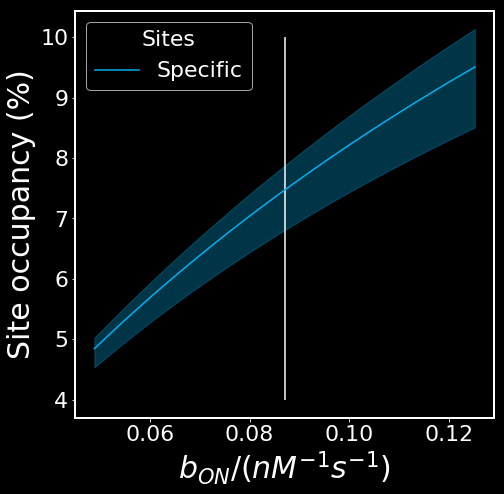

In [105]:
plt.plot(b_ON_OAT, 100 * Y_bONs_2s[:, var['CBS']] / S2, color=(0/255, 176/255, 240/255, 1), label='Specific')
plt.fill_between(b_ON_OAT, 100*Y_bONs_3s[:, var['CBS']]/S3, 100*Y_bONs_1s[:, var['CBS']]/S1, color=(0/255, 176/255, 240/255, 0.3))
plt.vlines(fitted_bON_mean, 4, 10, color='w')
plt.legend(title='Sites', title_fontsize=medium_size)

plt.xlabel(r'$b_{ON} / (nM^{-1}s^{-1})$')
plt.ylabel('Site occupancy (%)')

medium_size = 22
large_size = 30
#plt.xlim([0, 40])
#plt.xticks(np.around(np.linspace(0.1, 3, num=6, endpoint=True), decimals=1))
plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)